In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random

In [3]:
# This is used to just completely load the training set into memory
FILE = '/home/walter/Desktop/DMT_data/training_set_VU_DM_2014.csv'
data = pd.read_csv(FILE)

In [ ]:
# This is used to make a quick selection of the data, just so you can test out some code without having to worry about 
# the memory stuff. 
data.iloc[0:10000:].to_csv('data_selection.csv', index=False)

In [3]:
# Load in the selection
FILE_SELECTION = '/home/walter/Desktop/DMT_data/data_selection.csv'
data = pd.read_csv(FILE_SELECTION)
print(data)

      srch_id            date_time  site_id  visitor_location_country_id  \
0           1  2013-04-04 08:32:15       12                          187   
1           1  2013-04-04 08:32:15       12                          187   
2           1  2013-04-04 08:32:15       12                          187   
3           1  2013-04-04 08:32:15       12                          187   
4           1  2013-04-04 08:32:15       12                          187   
5           1  2013-04-04 08:32:15       12                          187   
6           1  2013-04-04 08:32:15       12                          187   
7           1  2013-04-04 08:32:15       12                          187   
8           1  2013-04-04 08:32:15       12                          187   
9           1  2013-04-04 08:32:15       12                          187   
10          1  2013-04-04 08:32:15       12                          187   
11          1  2013-04-04 08:32:15       12                          187   
12          

In [4]:
# This section is used to slice up the data in specific searches, grouping all information of one srch_id together. 
# This is saved in the 'searches' list, searches[0] returns a pandas dataframe for the first srch_id, searches[1] for 
# the second srch_id, etc. 

maxn_searches = 3
n_searches = 0
srch_id_begin_index = 0
searches = []

for i in range(1, len(data['srch_id'])): 
    
    if data['srch_id'][i] != data['srch_id'][i-1]:
        searches.append(data.iloc[srch_id_begin_index:i])
        srch_id_begin_index = i
        n_searches += 1
        
    if n_searches >= maxn_searches: 
        break
        
print(searches[0].loc[:, ['position', 'booking_bool']])

    position  booking_bool
0         27             0
1         26             0
2         21             0
3         34             0
4          4             0
5          7             0
6         18             0
7         35             0
8          3             0
9         10             0
10        20             0
11        19             0
12        13             1
13         2             0
14        15             0
15        31             0
16        23             0
17        36             0
18         8             0
19         6             0
20        28             0
21         1             0
22        32             0
23        12             0
24        24             0
25        37             0
26        33             0
27        29             0


In [35]:
# Function to add a column with normalized position to the data. This can be done for every srch_id. 
# This is useful for generalization. 1 means high listing, close to 0 means low listing. 
def normalize_position(df): 
    length = df['position'].max()
    df['norm_pos'] = (length + 1 - df['position']) / length
    return df
    
    
print(normalize_position(searches[0]))

    srch_id            date_time  site_id  visitor_location_country_id  \
0         1  2013-04-04 08:32:15       12                          187   
1         1  2013-04-04 08:32:15       12                          187   
2         1  2013-04-04 08:32:15       12                          187   
3         1  2013-04-04 08:32:15       12                          187   
4         1  2013-04-04 08:32:15       12                          187   
5         1  2013-04-04 08:32:15       12                          187   
6         1  2013-04-04 08:32:15       12                          187   
7         1  2013-04-04 08:32:15       12                          187   
8         1  2013-04-04 08:32:15       12                          187   
9         1  2013-04-04 08:32:15       12                          187   
10        1  2013-04-04 08:32:15       12                          187   
11        1  2013-04-04 08:32:15       12                          187   
12        1  2013-04-04 08:32:15      

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [9]:
# Length of total training data: 4958347, number of unique properties in training data: 129113
# So, on average this many listings per property. Hence, it's useful to include some extra property data. 
print(4958347 / 129113)


def property_data(df): 
    
    """
    The plan is to find the average, standard deviation and median for prop_starrating and for all attributes 
    that have a float value (except for gross_booking_usd as it's not available in the test set, and 
    visitor_hist_starrating and visitor_hist_adr_usd because they're not really characteristics of the property
    itself and competitor data due to high amount of missing data) for each prop_id. We then add these values
    as new attributes to the main dataset. 
    """
    
    attributes = ['prop_starrating', 
                  'prop_review_score',
                  'prop_location_score1',
                  'prop_location_score2',
                  'prop_log_historical_price',
                  'price_usd',
                  'srch_query_affinity_score',
                  'orig_destination_distance']
    
    # Get the number indices of the desired attributes, this is needed later for easy referencing
    header = pd.Index(list(df))
    attributes_n = []
    for i in range(0, len(attributes)): 
        attributes_n.append(header.get_loc(attributes[i]))
    header = pd.Index(list(df))  # Update the header
        
    # Add empty columns for all the new variables
    for attribute in attributes: 
        df['%s_avg' % attribute] = 0
        df['%s_stddev' % attribute] = 0
        df['%s_median' % attribute] = 0
    
    # Get a list of all unique prop_ids
    prop_ids = df['prop_id'].unique()
    
    # For each unique property
    for prop_id in tqdm(prop_ids[0:100]): 
        
        # Find all instances of that property and remember where they occur
        indices = []
        for i in range(0, len(df['prop_id'])): 
            if df['prop_id'][i] == prop_id: 
                indices.append(i)     
        
        # Add the mean, standard deviation and median of an attribute as new attributes to all instances of prop_id
        for attribute in attributes_n:
            mean = float(df.iloc[indices, [attribute]].mean())
            stddev = float(df.iloc[indices, [attribute]].std())
            median = float(df.iloc[indices, [attribute]].median())

            df.iloc[indices, [header.get_loc('%s_avg' % header[attribute])]] = mean
            df.iloc[indices, [header.get_loc('%s_stddev' % header[attribute])]] = stddev
            df.iloc[indices, [header.get_loc('%s_median' % header[attribute])]] = median
            
    print(df)

    return df        
    
    
property_data(data)

  0%|          | 0/1000 [00:00<?, ?it/s]

38.40315847358515


100%|██████████| 1000/1000 [02:15<00:00,  7.40it/s]


      srch_id            date_time  site_id  visitor_location_country_id  \
0           1  2013-04-04 08:32:15       12                          187   
1           1  2013-04-04 08:32:15       12                          187   
2           1  2013-04-04 08:32:15       12                          187   
3           1  2013-04-04 08:32:15       12                          187   
4           1  2013-04-04 08:32:15       12                          187   
5           1  2013-04-04 08:32:15       12                          187   
6           1  2013-04-04 08:32:15       12                          187   
7           1  2013-04-04 08:32:15       12                          187   
8           1  2013-04-04 08:32:15       12                          187   
9           1  2013-04-04 08:32:15       12                          187   
10          1  2013-04-04 08:32:15       12                          187   
11          1  2013-04-04 08:32:15       12                          187   
12          

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,prop_log_historical_price_median,price_usd_avg,price_usd_stddev,price_usd_median,srch_query_affinity_score_avg,srch_query_affinity_score_stddev,srch_query_affinity_score_median,orig_destination_distance_avg,orig_destination_distance_stddev,orig_destination_distance_median
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,4.955,96.570,11.596551,96.570,NaN,NaN,NaN,7500.57,NaN,7500.57
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,5.030,136.830,47.955982,136.830,NaN,NaN,NaN,7498.58,NaN,7498.58
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,4.935,146.560,47.008459,146.560,NaN,NaN,NaN,7498.70,NaN,7498.70
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,4.390,335.170,378.443549,335.170,NaN,NaN,NaN,7501.03,NaN,7501.03
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,4.920,121.690,30.957135,121.690,NaN,NaN,NaN,7499.61,NaN,7499.61
5,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,30184,4,4.5,...,5.195,154.320,57.982756,154.320,NaN,NaN,NaN,7499.78,NaN,7499.78
6,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,44147,3,3.5,...,4.765,114.055,21.630396,114.055,NaN,NaN,NaN,7498.57,NaN,7498.57
7,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,50984,2,0.0,...,4.140,85.370,NaN,85.370,NaN,NaN,NaN,NaN,NaN,NaN
8,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,53341,4,4.0,...,5.180,118.170,45.085128,118.170,NaN,NaN,NaN,7499.53,NaN,7499.53
9,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,56880,4,4.0,...,5.140,202.200,111.001623,202.200,NaN,NaN,NaN,7499.84,NaN,7499.84


Text(0.5,0,'Number of times property is clicked/booked')

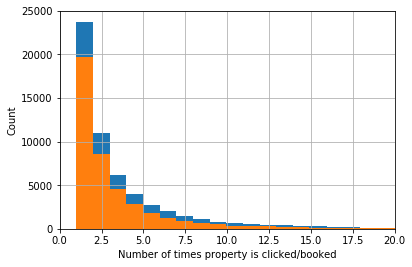

In [13]:
# Make a plot indicating how often a single property is clicked on or booked

clicked_properties = data['prop_id'].where(data['click_bool']==1)
clicked_properties = clicked_properties.value_counts()
booking_properties = data['prop_id'].where(data['booking_bool']==1)
booking_properties = booking_properties.value_counts()
clicked_properties.hist(bins = max(clicked_properties)) 
booking_properties.hist(bins = max(booking_properties))
plt.xlim(0,20)
plt.ylabel('Count')
plt.xlabel('Number of times property is clicked/booked')

In [6]:
# Try and do some data sampling

srch_id_begin_index = 0
indices = []

# For all indices
for index in tqdm(range(1, len(data['srch_id']))): 
    
    # If the listing was clicked on or booked, then we save the index of that listing
    if data['click_bool'][index] == 1 or data['booking_bool'][index] == 1: 
        indices.append(index)    
  
    # If we find the beginning of the next srch_id
    if data['srch_id'][index] != data['srch_id'][index-1]:
        
        # We pick three random indices from the domain of the previous srch_id
        random_indices = []
        for i in range(0, 3): 
            random_indices.append(random.randint(srch_id_begin_index, index))
            
        # If these randomly picked indices were not saved yet, we save them, otherwise we ignore them (don't want doubles)
        for i in random_indices: 
            if i not in indices[len(indices)-10:]: 
                indices.append(i)
                
        # Set the start of the domain of the next srch_id
        srch_id_begin_index = index
        
        
print(len(indices))
    


100%|██████████| 4958346/4958346 [06:15<00:00, 13205.68it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




In [8]:
len(indices)
# This is used to save the sampleddata
data.iloc[indices].to_csv('data_sampled.csv', index=False)

In [10]:
print(indices[0:100])

[12, 25, 19, 14, 59, 41, 54, 42, 63, 61, 60, 62, 68, 85, 66, 71, 90, 92, 117, 99, 145, 129, 120, 168, 160, 173, 164, 194, 207, 197, 185, 211, 236, 229, 238, 243, 274, 241, 265, 244, 280, 312, 310, 305, 291, 319, 321, 344, 323, 346, 360, 359, 365, 387, 372, 373, 383, 402, 419, 406, 416, 425, 427, 428, 431, 426, 457, 451, 444, 434, 467, 486, 484, 469, 509, 504, 499, 508, 522, 542, 543, 529, 536, 538, 568, 560, 571, 586, 610, 598, 600, 624, 642, 625, 629, 653, 658, 648, 656, 661]
